In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
# Importações padrão
import numpy as np  # Operações com arrays numéricos
import os  # Operações com sistema de arquivos
import random  # Funções de aleatoriedade
import time  # Medições de tempo

# Avaliação de modelos
from sklearn.metrics import classification_report  # Métricas para classificação
from sklearn.model_selection import train_test_split

# Manipulação de imagens e dados
import pandas as pd  # Manipulação de dados tabulares
from PIL import Image  # Manipulação de imagens

# PyTorch: biblioteca de deep learning
import torch  # Framework principal para operações de tensores
import torch.nn as nn  # Definição de redes neurais
from torch.utils.data import Dataset, DataLoader, Subset, SubsetRandomSampler, random_split  # Gerenciamento de datasets e loaders
import torchvision.transforms as T  # Transformações em imagens

# Visualização de dados
import matplotlib.pyplot as plt  # Visualização de gráficos
import seaborn as sn  # Visualização de dados com gráficos mais estilizados

# Define o caminho para a pasta que contém as imagens
IMAGES_FOLDER = '/content/drive/MyDrive/breast-images'

# Lista e ordena os caminhos das imagens no diretório especificado
image_paths = sorted(
    [os.path.join(IMAGES_FOLDER, file) for file in os.listdir(IMAGES_FOLDER)]
)

# Define as categorias de classificação das imagens
CATEGORIES = ['benigno', 'maligno']

# Define o caminho para o arquivo CSV das features
FEATURES_PATH = '/content/drive/MyDrive/features-radiomics/features_filtradas_rfe.csv'

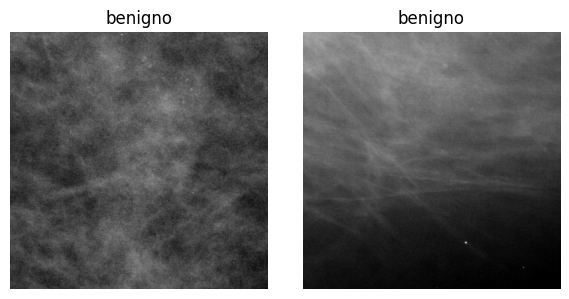

In [ ]:
def plot_images_side_by_side(image_paths):
    """
    Plota imagens lado a lado.

    Args:
        image_paths (list): Lista de caminhos para as imagens a serem plotadas.
    """
    num_images = len(image_paths)

    if num_images == 0:
        raise ValueError("A lista de caminhos de imagem está vazia.")

    fig, axes = plt.subplots(1, num_images, figsize=(3 * num_images, 3))

    # Se houver apenas uma imagem, garante que axes seja uma lista
    if num_images == 1:
        axes = [axes]

    label_map = {'0_': 0, '2_': 1}

    for image_path, ax in zip(image_paths, axes):
        image = Image.open(image_path)
        file_prefix = os.path.basename(image_path)[:2]
        label = label_map.get(file_prefix, 'Desconhecido')

        ax.imshow(image, cmap='gray')
        ax.axis('off')
        ax.set_title(CATEGORIES[label] if label in label_map.values() else label)

    plt.tight_layout()
    plt.show()

# Exibe as duas primeiras imagens
plot_images_side_by_side(image_paths[:2])

In [ ]:
def print_image_characteristics(image_path):
    """
    Imprime as características de uma imagem.

    Args:
        image_path (str): Caminho para a imagem a ser analisada.
    """
    img = Image.open(image_path)
    img_array = np.array(img)

    width, height = img.size
    dimensions = img_array.ndim

    mean_pixel_value = img_array.mean()
    min_pixel_value = img_array.min()
    max_pixel_value = img_array.max()

    print(f"""
    Imagem: {image_path}
    Dimensões: {width}x{height}
    Número de dimensões: {dimensions}D
    Formato: {img.format}
    Modo: {img.mode}
    Valor médio dos pixels: {mean_pixel_value:.2f}
    Valor mínimo dos pixels: {min_pixel_value}
    Valor máximo dos pixels: {max_pixel_value}
    {'-' * 40}
    """)

def display_images_characteristics(image_paths):
    """
    Exibe as características de um conjunto de imagens.

    Args:
        image_paths (list): Lista de caminhos para as imagens a serem analisadas.
    """
    if not image_paths:
        raise ValueError("A lista de caminhos de imagem está vazia.")

    for image_path in image_paths:
        print_image_characteristics(image_path)

# Exibe as características das duas primeiras imagens
display_images_characteristics(image_paths[:2])


    Imagem: /content/drive/MyDrive/breast-images/0_Calc-Test_P_00038_LEFT_CC_1_roi.png
    Dimensões: 512x512
    Número de dimensões: 2D
    Formato: PNG
    Modo: I;16
    Valor médio dos pixels: 24601.16
    Valor mínimo dos pixels: 17130
    Valor máximo dos pixels: 42559
    ----------------------------------------
    

    Imagem: /content/drive/MyDrive/breast-images/0_Calc-Test_P_00038_LEFT_MLO_1_roi.png
    Dimensões: 512x512
    Número de dimensões: 2D
    Formato: PNG
    Modo: I;16
    Valor médio dos pixels: 15226.51
    Valor mínimo dos pixels: 0
    Valor máximo dos pixels: 54470
    ----------------------------------------
    


##Preparando dataset

In [ ]:
class BreastDataset(Dataset):
    """
    Classe para representar um conjunto de dados de imagens de mama.

    Args:
        image_paths (list): Lista de caminhos das imagens.
        features_path (str): Caminho para o arquivo CSV das features radiômicas.
        transform (callable, optional): Transformações a serem aplicadas nas imagens. Padrão é None.
        feature_transform (callable, optional): Transformações a serem aplicadas nas features. Padrão é None.
    """

    def __init__(self, image_paths, features_path, transform=None, feature_transform=None):
        """
        Inicializa o conjunto de dados filtrando os caminhos válidos e carregando as features.

        Args:
            image_paths (list): Lista de caminhos das imagens.
            features_path (str): Caminho para o arquivo CSV das features radiômicas.
            transform (callable, optional): Transformações a serem aplicadas nas imagens. Padrão é None.
            feature_transform (callable, optional): Transformações a serem aplicadas nas features. Padrão é None.
        """
        self.transform = transform
        self.feature_transform = feature_transform
        self.valid_image_paths = self._filter_valid_paths(image_paths)
        self.features = self._load_features(features_path)

    @staticmethod
    def _filter_valid_paths(image_paths):
        """
        Filtra e retorna os caminhos válidos de imagens, ou seja, aqueles que começam com '0_' ou '2_'.

        Args:
            image_paths (list): Lista de caminhos das imagens.

        Returns:
            list: Lista de caminhos válidos.
        """
        valid_prefixes = ('/content/drive/MyDrive/breast-images/0_',
                          '/content/drive/MyDrive/breast-images/2_')
        return [path for path in image_paths if path.startswith(valid_prefixes)]

    @staticmethod
    def _load_features(features_path):
        """
        Carrega as features radiômicas a partir do arquivo CSV.

        Args:
            features_path (str): Caminho para o arquivo CSV das features radiômicas.

        Returns:
            DataFrame: DataFrame contendo as features radiômicas.
        """
        features = pd.read_csv(features_path)
        features.set_index(features.columns[0], inplace=True)
        return features

    def __len__(self):
        """Retorna o número total de imagens válidas no conjunto de dados."""
        return len(self.valid_image_paths)

    def __getitem__(self, idx):
        """
        Retorna a imagem, o rótulo e as features correspondentes ao índice fornecido.

        Args:
            idx (int): Índice da imagem.

        Returns:
            tuple: Imagem transformada, rótulo correspondente e features.
        """
        image_path = self.valid_image_paths[idx]
        image = self._load_image(image_path)
        label = self._get_label(image_path)
        features = self._get_features(idx)

        if self.transform:
            image = self.transform(image)

        if self.feature_transform:
            features = self.feature_transform(features)

        return image, label, features

    @staticmethod
    def _load_image(image_path):
        """
        Carrega a imagem a partir do caminho e converte imagens de 16 bits para 8 bits, se necessário.

        Args:
            image_path (str): Caminho da imagem.

        Returns:
            Image: Imagem carregada.
        """
        image = Image.open(image_path)

        if image.mode == 'I;16':
            image = image.point(lambda i: i * (255.0 / 65535.0)).convert('L')

        return image

    @staticmethod
    def _get_label(image_path):
        """
        Retorna o rótulo com base no prefixo do caminho da imagem.

        Args:
            image_path (str): Caminho da imagem.

        Returns:
            int: 0 para imagens com prefixo '0_', 1 para imagens com prefixo '2_'.
        """
        return 0 if image_path.startswith('/content/drive/MyDrive/breast-images/0_') else 1

    def _get_features(self, idx):
        """
        Retorna as features radiômicas correspondentes ao índice da imagem.

        Args:
            idx (int): Índice da imagem.

        Returns:
            Tensor: Features radiômicas correspondentes.
        """
        features_row = self.features.iloc[idx]
        features = features_row.iloc[:-1].astype(float)  # Considera apenas as colunas intermediárias
        return torch.tensor(features.values, dtype=torch.float32)

    def get_image_path(self, idx):
        """
        Retorna o caminho da imagem correspondente ao índice fornecido.

        Args:
            idx (int): Índice da imagem.

        Returns:
            str: Caminho da imagem.
        """
        return self.valid_image_paths[idx]


# Define as transformações para as imagens
transform_no_normalize = T.Compose([T.ToTensor()])


# Cria uma instância do conjunto de dados
dataset = BreastDataset(image_paths, FEATURES_PATH, transform=transform_no_normalize)

# Obtém as labels do dataset
targets = [dataset[i][1] for i in range(len(dataset))]  # Acessando as labels

# Divide em treino e teste com a mesma proporção de classes
train_idx, test_idx = train_test_split(
    np.arange(len(targets)), test_size=0.2, stratify=targets, random_state=42
)

# Usando Subset para criar datasets de treino e teste no PyTorch
train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

# Inicializa listas para acumular imagens e features
all_train_images = []
all_train_features = []

# Itera sobre o conjunto de treinamento para acumular imagens e features
for image_tensor, _, features_tensor in train_dataset:
    all_train_images.append(image_tensor)
    all_train_features.append(features_tensor)

# Empilha todas as imagens e features em tensores únicos
train_images_tensor = torch.stack(all_train_images)
train_features_tensor = torch.stack(all_train_features)

# Calcula a média e o desvio padrão das imagens
train_images_mean = train_images_tensor.mean().item()
train_images_std = train_images_tensor.std().item()

# Calcula a média e o desvio padrão das features
train_features_mean = train_features_tensor.mean(dim=0)
train_features_std = train_features_tensor.std(dim=0)

# Define as transformações de normalização das imagens
normalize_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(mean=train_images_mean, std=train_images_std)
])

# Define a transformação de normalização das features
def normalize_features(features):
    return (features - train_features_mean) / train_features_std

# Atribui a transformação de normalização ao conjunto de dados de treinamento e teste
train_dataset.dataset.transform = normalize_transform
train_dataset.dataset.feature_transform = normalize_features
test_dataset.dataset.transform = normalize_transform
test_dataset.dataset.feature_transform = normalize_features

# Exibe o número de imagens no dataset, treino e teste
print(f'Total de imagens: {len(dataset)}')
print(f'Imagens no treino: {len(train_dataset)}')
print(f'Imagens no teste: {len(test_dataset)}')

# Seleciona um índice aleatório do conjunto de treino
random_idx = random.randint(0, len(train_dataset) - 1)

# Obtém a imagem, o label e as features correspondentes
image, label, features = train_dataset[random_idx]

# Imprime o label e as features
print(f'Label: {label}')
print(f'Features: {features}')

Total de imagens: 1810
Imagens no treino: 1448
Imagens no teste: 362
Label: 0
Features: tensor([ 0.6549,  0.6068, -1.3862, -0.3538,  0.3669, -0.6986, -0.6562, -0.7767,
        -0.2640, -0.5625])


In [ ]:
# Seleciona um índice aleatório do conjunto de treino
random_idx = random.randint(0, len(train_dataset) - 1)

# Obtém a imagem, o label e as features correspondentes
image, label, features = train_dataset[random_idx]



# Imprime o label e as features
print(f'Label: {label}')
print(f'Features: {features}')

Label: 1
Features: tensor([-0.1193, -0.4016,  2.0431, -0.5003, -0.7798,  0.8842,  0.8404,  0.0800,
         0.4742,  1.1142])


In [ ]:
features = pd.read_csv(FEATURES_PATH)
features.set_index(features.columns[0], inplace=True)
features

features_row = features.iloc[5]
features = features_row.iloc[:-1].astype(float)  # Considera apenas as colunas intermediárias
features

,0_Calc-Test_P_00141_LEFT_MLO_1_roi.png
original_firstorder_90Percentile,5.518800e+04
original_firstorder_Energy,4.579820e+14
original_firstorder_Entropy,9.955355e+00
original_firstorder_Kurtosis,2.709728e+00
original_firstorder_Skewness,-2.784143e-01
original_glcm_Idmn,9.997705e-01
original_gldm_DependenceNonUniformityNormalized,7.634165e-01
original_ngtdm_Coarseness,3.625949e-04
original_ngtdm_Contrast,8.917568e-01
original_ngtdm_Strength,4.071494e+02


In [ ]:
print(features.values)

[ 5.51880000e+04  4.57981996e+14  9.95535479e+00  2.70972753e+00
 -2.78414320e-01  9.99770453e-01  7.63416486e-01  3.62594913e-04
  8.91756785e-01  4.07149375e+02]


In [ ]:
# Define o tamanho do batch para treinamento e teste
batch_size = 64

# Cria um DataLoader para o conjunto de treinamento
# shuffle=True garante que os dados sejam embaralhados em cada época para melhor generalização
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Cria um DataLoader para o conjunto de teste
# shuffle=False mantém a ordem dos dados, o que é útil para avaliação consistente
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Verifica se uma GPU com suporte a CUDA está disponível; caso contrário, utiliza a CPU
device = "cuda" if torch.cuda.is_available() else "cpu"

# Informa ao usuário qual dispositivo está sendo utilizado para execução
print(f"Rodando na {device}")

Rodando na cuda


In [ ]:
class ConvolutionalModel(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.num_features = num_features

        # Camadas convolucionais
        self.convlayers = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=(3, 3)),  # Entrada com 1 canal
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduz pela metade

            nn.Conv2d(16, 32, kernel_size=(3, 3)),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # Reduz pela metade novamente
        )

        self.featurelayers = nn.Sequential(
            nn.Linear(self.num_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

        # Tamanho da entrada para a camada linear baseado na saída da convolução
        # Assumindo que a entrada é sempre 256x256 e que as camadas de pooling reduzem para 62x62
        self.linearlayers = nn.Sequential(
            nn.Linear(32 * 126 * 126 +256, 256),  # Ajustado para a concatenação com as features
            nn.ReLU(),
            nn.Linear(256, 2),  # Saída para classificação binária
        )

    def forward(self, x, features):
        """Define a passagem de entrada pela rede."""
        x = self.convlayers(x)
        x = torch.flatten(x, 1)  # Achata a saída para entrada nas camadas lineares

        features = self.featurelayers(features)
        x = torch.cat((x, features), dim=1)  # Concatenar as features com a saída convolucional

        return self.linearlayers(x)

def train(model, train_loader, loss_function, optimizer):
    model.train()  # Modo treinamento
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels, features in train_loader:
        inputs, labels, features = inputs.to(device), labels.to(device), features.to(device)

        # Zera os gradientes
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, features)
        loss = loss_function(outputs, labels)

        # Backward pass e otimização
        loss.backward()
        optimizer.step()

        # Atualiza a perda acumulada
        running_loss += loss.item() * inputs.size(0)

        # Calcula as previsões corretas
        _, predicted = torch.max(outputs, 1)
        total_samples += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

    # Calcula a perda média e acurácia no conjunto de treino
    avg_loss = running_loss / len(train_loader.dataset)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy


def validate(model, test_loader, loss_function):
    model.eval()  # Modo de validação
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Desabilita o cálculo de gradientes
        for inputs, labels, features in test_loader:
            inputs, labels, features = inputs.to(device), labels.to(device), features.to(device)

            # Forward pass
            outputs = model(inputs, features)
            loss = loss_function(outputs, labels)

            # Atualiza a perda acumulada
            running_loss += loss.item() * inputs.size(0)

            # Calcula as previsões corretas
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

    # Calcula a perda média e acurácia no conjunto de validação
    avg_loss = running_loss / len(test_loader.dataset)
    accuracy = correct_predictions / total_samples

    return avg_loss, accuracy


def get_predictions(model, test_loader):
    model.eval()  # Modo de avaliação
    y_true = []
    y_pred = []

    with torch.no_grad():  # Desabilita o cálculo de gradientes
        for inputs, labels, features in test_loader:
            inputs, labels, features = inputs.to(device), labels.to(device), features.to(device)
            outputs = model(inputs, features)

            # Obtém as previsões
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())  # Adiciona os rótulos verdadeiros
            y_pred.extend(predicted.cpu().numpy())  # Adiciona as previsões

    return y_true, y_pred

In [ ]:
# Instancia o modelo e move para o dispositivo apropriado (CPU ou GPU)
conv_model = ConvolutionalModel(10).to(device)

#Escolhendo os hiperparâmetros de otimização

# Definição da função de perda como Cross Entropy Loss
loss_function = nn.CrossEntropyLoss()

# Definição do otimizador usando Stochastic Gradient Descent (SGD) com taxa de aprendizado de 0.001
optimizer = torch.optim.SGD(conv_model.parameters(), lr=0.001)

# Definindo hiperparâmetros
num_epochs = 1001
early_stopping_patience = 10
min_validation_loss = float('inf')
patience_counter = 0
best_epoch = 0
best_test_accuracy = 0

# Listas para armazenar perdas e acurácias
training_losses = []
testing_losses = []
training_accuracies = []
testing_accuracies = []

# Iniciando o cronômetro
start_time = time.time()

# Laço de treinamento
for epoch in range(num_epochs):
    # Treinando o modelo
    train_loss, train_accuracy = train(conv_model, train_loader, loss_function, optimizer)
    training_losses.append(train_loss)
    training_accuracies.append(train_accuracy)

    # Validando o modelo
    test_loss, test_accuracy = validate(conv_model, test_loader, loss_function)
    testing_losses.append(test_loss)
    testing_accuracies.append(test_accuracy)

    # Calculando o tempo decorrido
    elapsed_time = time.time() - start_time
    print(f"Epoch: {epoch} | Loss: {test_loss:.5f} | Train Accuracy: {train_accuracy:.5f} | Test Accuracy: {test_accuracy:.5f} | {time.strftime('%H:%M:%S', time.gmtime(elapsed_time))}")

    # Verificando se a perda de validação melhorou
    if test_loss < min_validation_loss:
        min_validation_loss = test_loss
        patience_counter = 0
        best_epoch = epoch
        best_test_accuracy = test_accuracy
        torch.save(conv_model.state_dict(), '/content/drive/MyDrive/models/conv_model_images_features_0.pth')  # Salvando o melhor modelo
    else:
        patience_counter += 1

    # Verificando a condição de parada antecipada
    if patience_counter >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch}.")
        break

# Calculando o tempo total de treinamento
total_time = time.time() - start_time
print(f"Training complete in: {time.strftime('%H:%M:%S', time.gmtime(total_time))}")

# Resultados finais
print(f"\nEarly stopping occurred at epoch {epoch} with best_epoch = {best_epoch} and best_test_accuracy = {best_test_accuracy:.5f}")

# Obtendo previsões
y_true, y_pred = get_predictions(conv_model, test_loader)
test_accuracy = np.mean(np.array(y_true) == np.array(y_pred)) * 100
print(f"\nAccuracy on test set: {test_accuracy:.2f}%")

# Relatório de classificação
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=CATEGORIES))

Epoch: 0 | Loss: 0.68986 | Train Accuracy: 0.55110 | Test Accuracy: 0.60221 | 00:00:24
Epoch: 1 | Loss: 0.68645 | Train Accuracy: 0.61257 | Test Accuracy: 0.59669 | 00:00:53
Epoch: 2 | Loss: 0.67584 | Train Accuracy: 0.61740 | Test Accuracy: 0.59945 | 00:01:21
Epoch: 3 | Loss: 0.66857 | Train Accuracy: 0.63329 | Test Accuracy: 0.61878 | 00:01:49
Epoch: 4 | Loss: 0.66026 | Train Accuracy: 0.64779 | Test Accuracy: 0.63812 | 00:02:17
Epoch: 5 | Loss: 0.65521 | Train Accuracy: 0.65677 | Test Accuracy: 0.65746 | 00:02:45
Epoch: 6 | Loss: 0.64624 | Train Accuracy: 0.67196 | Test Accuracy: 0.66298 | 00:03:14
Epoch: 7 | Loss: 0.63755 | Train Accuracy: 0.67196 | Test Accuracy: 0.68232 | 00:03:42
Epoch: 8 | Loss: 0.63683 | Train Accuracy: 0.68715 | Test Accuracy: 0.67127 | 00:04:10
Epoch: 9 | Loss: 0.63529 | Train Accuracy: 0.68646 | Test Accuracy: 0.69613 | 00:04:38
Epoch: 10 | Loss: 0.61924 | Train Accuracy: 0.69682 | Test Accuracy: 0.70166 | 00:05:06
Epoch: 11 | Loss: 0.61888 | Train Accuracy

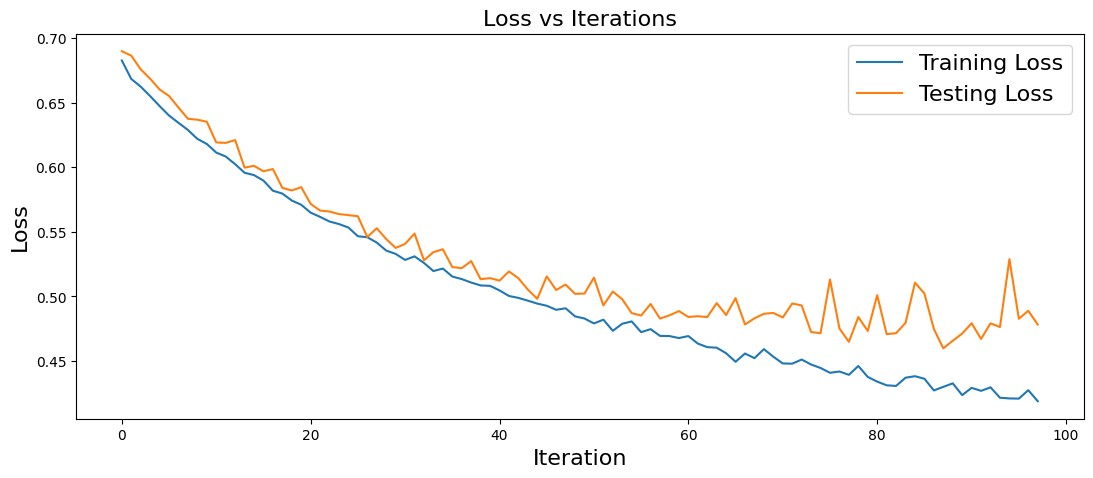

In [ ]:
def plot_losses(losses):
    """
    Plota as perdas ao longo das iterações.

    Args:
        losses (dict): Um dicionário onde as chaves são os nomes das perdas
                       e os valores são listas de valores de perda.
    """
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()

    # Iterar sobre cada conjunto de perdas e plotar
    for loss_name, loss_values in losses.items():
        ax.plot(loss_values, label=loss_name)

    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")  # Eixo X como Iteração
    ax.set_ylabel("Loss", fontsize="16")       # Eixo Y como Perda
    ax.set_title("Loss vs Iterations", fontsize="16")  # Título do gráfico
    plt.show()

# Dicionário de perdas de treino e teste
conv_losses = {"Training Loss": training_losses, "Testing Loss": testing_losses}

# Plotar as perdas
plot_losses(conv_losses)

In [ ]:
def create_confusion_matrix(model, loader, num_classes):
    """
    Cria uma matriz de confusão para as previsões do modelo.
    """
    confusion_matrix = torch.zeros(num_classes, num_classes, dtype=torch.int64)

    # Desativar o cálculo do gradiente para a avaliação
    with torch.no_grad():
        for images, labels, features in loader:
            images, labels, features = images.to(device), labels.to(device), features.to(device)
            outputs = model(images, features)
            _, predictions = torch.max(outputs, 1)

            # Atualiza a matriz de confusão com as previsões
            for true_label, predicted_label in zip(labels.view(-1), predictions.view(-1)):
                confusion_matrix[true_label, predicted_label] += 1

    return confusion_matrix


def evaluate_accuracy(model, dataloader, classes, verbose=True):
    """
    Avalia a acurácia do modelo e imprime a acurácia por classe.
    """
    confusion_matrix = create_confusion_matrix(model, dataloader, len(classes))

    if verbose:
        total_correct = 0.0
        total_predictions = 0.0

        # Calcula e imprime a acurácia para cada classe
        for i, classname in enumerate(classes):
            correct_count = confusion_matrix[i][i].item()  # Previsões corretas para a classe
            class_predictions = torch.sum(confusion_matrix[i]).item()  # Total de previsões para a classe

            total_correct += correct_count
            total_predictions += class_predictions

            accuracy = 100 * float(correct_count) / class_predictions if class_predictions > 0 else 0
            print(f"Accuracy for class {classname:5s} is: {accuracy:.1f} %")

    # Imprime a acurácia global
    global_accuracy = 100 * total_correct / total_predictions
    print(f"Global accuracy is {global_accuracy:.1f} %")

    return confusion_matrix


def test_model(model, dataloader, classes):
    """
    Testa o modelo e calcula a acurácia por classe.
    """
    correct_predictions = {classname: 0 for classname in classes}
    total_predictions = {classname: 0 for classname in classes}

    # Desativa o cálculo do gradiente durante o teste
    with torch.no_grad():
        for images, labels, features in dataloader:
            images, labels, features = images.to(device), labels.to(device), features.to(device)
            outputs = model(images, features)
            _, predictions = torch.max(outputs, 1)

            # Atualiza contadores de acurácia
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_predictions[classes[label]] += 1
                total_predictions[classes[label]] += 1

    # Calcula e imprime a acurácia por classe
    total_correct = 0.0
    total_predictions_all = 0.0
    for classname, correct_count in correct_predictions.items():
        total_correct += correct_count
        total_predictions_all += total_predictions[classname]

        accuracy = 100 * float(correct_count) / total_predictions[classname] if total_predictions[classname] > 0 else 0
        print(f"Accuracy for class {classname:5s} is: {accuracy:.1f} %")

    # Imprime a acurácia global
    global_accuracy = 100 * total_correct / total_predictions_all
    print(f"Global accuracy is {global_accuracy:.1f} %")


# Exemplo de uso da função evaluate_accuracy
confusion_matrix = evaluate_accuracy(conv_model, test_loader, CATEGORIES)

Accuracy for class benigno is: 88.9 %
Accuracy for class maligno is: 65.0 %
Global accuracy is 78.2 %


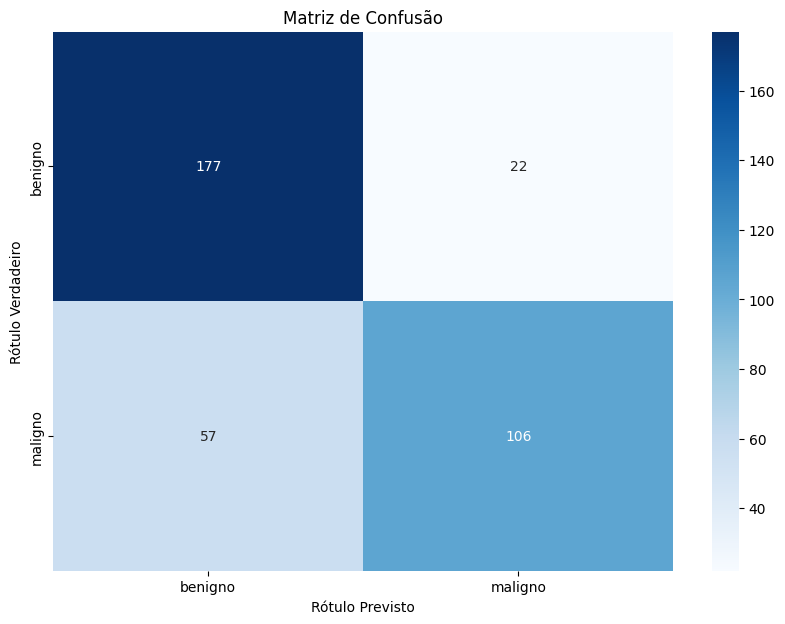

In [ ]:
def plot_confusion_matrix(confusion_matrix, class_names):
    # Configura o tamanho da figura
    plt.figure(figsize=(10, 7))

    # Plota a matriz de confusão usando um heatmap
    sn.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues",
                 xticklabels=class_names, yticklabels=class_names)

    # Define os rótulos dos eixos
    plt.ylabel('Rótulo Verdadeiro')  # Rótulo real das classes
    plt.xlabel('Rótulo Previsto')     # Rótulo previsto pelo modelo
    plt.title('Matriz de Confusão')   # Título do gráfico
    plt.show()                        # Exibe o gráfico

# Chama a função para plotar a matriz de confusão
plot_confusion_matrix(confusion_matrix, CATEGORIES)

#Testando o Modelo

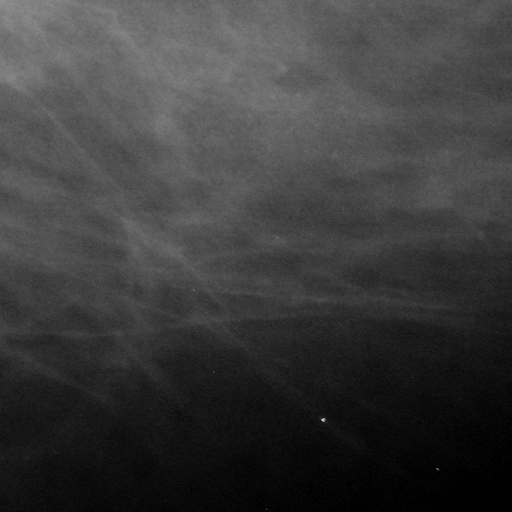

In [ ]:
img_b = Image.open('/content/drive/MyDrive/breast-images/0_Calc-Test_P_00038_LEFT_MLO_1_roi.png')
img_b

In [ ]:
image = img_b.point(lambda i: i * (255.0 / 65535.0)).convert('L')
img_tensor = normalize_transform(image)
batch = img_tensor.unsqueeze(0).to(device)

conv_model.eval()

ConvolutionalModel(
  (convlayers): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (featurelayers): Sequential(
    (0): Linear(in_features=10, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
  )
  (linearlayers): Sequential(
    (0): Linear(in_features=508288, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=2, bias=True)
  )
)

In [ ]:
# Carrega o arquivo CSV em um DataFrame
features_df = pd.read_csv(FEATURES_PATH)

# Imprime a primeira linha do DataFrame
features_df.head(1)

,Transformed Image Names,original_firstorder_90Percentile,original_firstorder_Energy,original_firstorder_Entropy,original_firstorder_Kurtosis,original_firstorder_Skewness,original_glcm_Idmn,original_gldm_DependenceNonUniformityNormalized,original_ngtdm_Coarseness,original_ngtdm_Contrast,original_ngtdm_Strength,class
0,0_Calc-Test_P_00038_LEFT_CC_1_roi.png,54244.0,1.631849e+14,8.461668,2.729958,-0.000881,0.995891,0.86547,0.000123,5.416673,42.367873,BENIGN


In [ ]:
img_b_features = features_df.iloc[0, 1:-1].values

img_b_features

array([54244.0, 163184929757953.0, 8.461668147380134, 2.729957784107729,
       -0.0008806582434136, 0.995891361696046, 0.8654697659333909,
       0.0001226101670197, 5.416673474916249, 42.36787257453175],
      dtype=object)

In [ ]:
features_tensor = torch.tensor(img_b_features.tolist(), dtype=torch.float32)

feature_tensor = features_tensor.unsqueeze(0).to(device)

In [ ]:
output = conv_model(batch, feature_tensor)
output

tensor([[ 1.0854e+13, -1.0272e+13]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
logits = torch.nn.functional.softmax(output, dim=1) * 100
prob_dict = {}
for i, classname in enumerate(CATEGORIES):
  prob = logits[0][i].item()
  print(f"{classname} score: {prob:.2f}")
  prob_dict[classname] = [prob]

benigno score: 100.00
maligno score: 0.00


<Axes: >

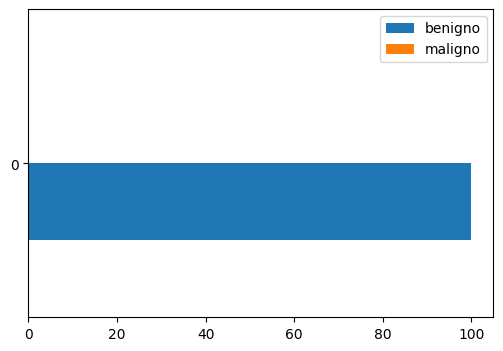

In [ ]:
df_prob = pd.DataFrame.from_dict(prob_dict)
df_prob.plot(kind='barh', figsize=(6, 4))